In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import scipy as sp
import json
import os
import math

import matplotlib
from matplotlib import pyplot as plt
plt.style.use('ggplot')

#from mpl_toolkits.basemap import Basemap, cm
from matplotlib.path import Path

from datetime import datetime
from dateutil import tz
import time
import datetime
import calendar


from stravalib.client import Client
from stravalib import unithelper

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:

from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.
''')


In [4]:
m_to_yd = 1.09361
json_data=open('{0}/strava_credentials.json'.format(os.getenv("HOME"))).read()
credentials = json.loads(json_data)
client = Client(access_token=credentials['AccessToken'])

In [8]:
def rolling_haversine(df):
    radius = 6371 # km
    
    d_ll = df.rolling(2).apply(lambda x: math.radians(x[1]-x[0]))
    ll = df.lat.rolling(2).apply(lambda x: math.cos(math.radians(x[0])) * math.cos(math.radians(x[1])))
    
    a = d_ll.lat.apply(lambda x: math.sin(x/2) * math.sin(x/2)) + \
        ll * d_ll.lon.apply(lambda x: math.sin(x/2) * math.sin(x/2))
    c = 2 * a.apply(lambda x: math.atan2(math.sqrt(x), math.sqrt(1-x)) )
    
    d = radius * c
    
    return d


In [5]:
activities = client.get_activities()

my_swims = pd.DataFrame([{'name':activity.name, 
                          'id': activity.id, 
                          'stroke_count': 2 * activity.average_cadence if activity.average_cadence is not None else None,
                          'average_speed':float(unithelper.meters_per_second(activity.average_speed)),
                          'elapsed_time':unithelper.timedelta_to_seconds(activity.elapsed_time), 'start_date': activity.start_date,
                          'distance':float(unithelper.meters(activity.distance)) * m_to_yd} 
                         for activity in activities if activity.type=='Swim' and activity.map.summary_polyline is not None])
my_swims = my_swims.set_index('start_date')
my_swims.index = pd.DatetimeIndex(my_swims.index)
my_swims.index = my_swims.index.tz_convert('US/Pacific')
my_swims['month'] = my_swims.index.month
my_swims['month'] = my_swims['month'].apply(lambda x: calendar.month_abbr[x])
my_swims['ds_week_ending'] = my_swims.index.to_period('W').end_time

In [6]:
courses = pd.DataFrame()
courses_dict = {}
for activity in activities:
    if activity.type=='Swim' and activity.map.summary_polyline is not None:
        course = pd.DataFrame(client.get_activity_streams(activity.id, types=['latlng'], series_type='time')['latlng'].data,index=None, columns=['lat', 'lon']) 
        course['id'] = activity.id
        courses = courses.append(course)
        courses_dict[activity.id] = course


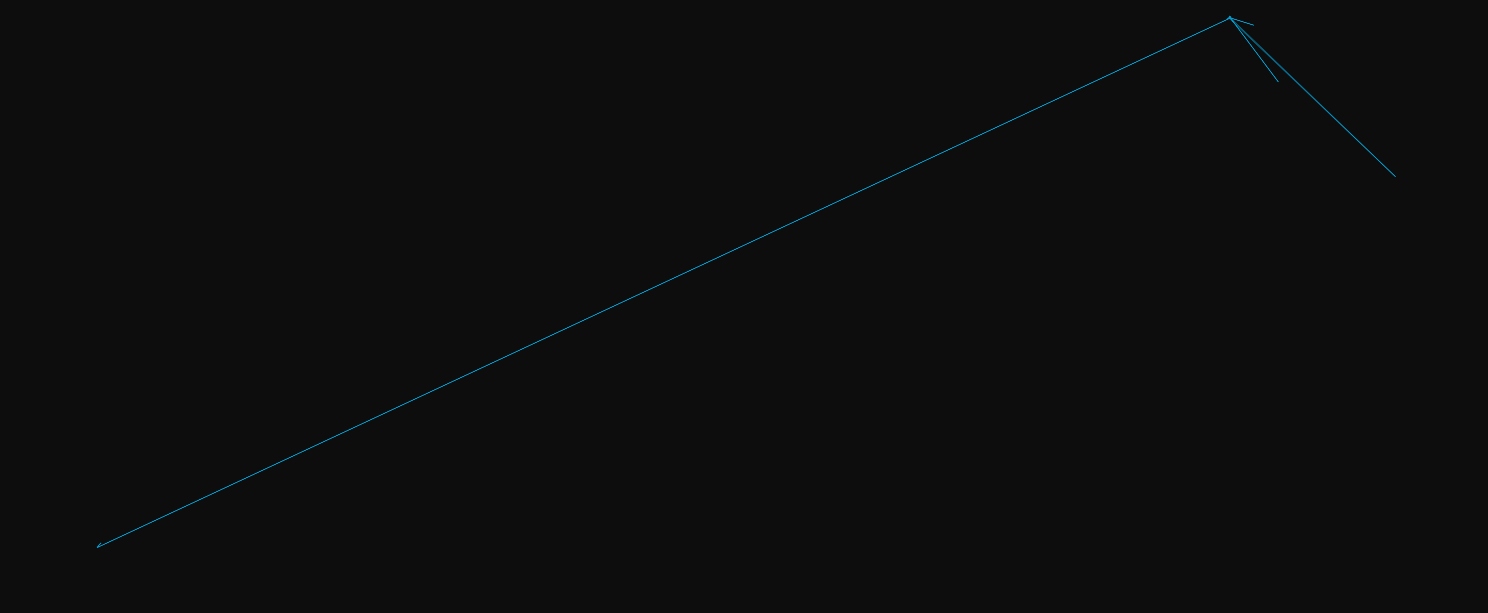

In [7]:
# one map per month and an overall one
fig = plt.figure(facecolor = '0.05')
ax = plt.Axes(fig, [0., 0., 1., 1.], )
ax.set_aspect('equal')
ax.set_axis_off()
fig.add_axes(ax)
plt.plot(courses.lon, courses.lat, color = 'deepskyblue', lw = 0.5, alpha = 0.8)

In [34]:
true_distance = {}
for swim_id in courses_dict.keys():
    if swim_id not in [766916495, 822123587, 821042032, 554752952]:
        true_distance[swim_id] = 1000 * rolling_haversine(courses_dict[swim_id]).sum() * m_to_yd
my_swims['approx_distance'] = my_swims.id.apply(lambda x: np.nan if x not in true_distance.keys() else true_distance[x])
my_swims['delta'] = my_swims['approx_distance'] - my_swims['distance']
my_swims['ratio'] = my_swims['approx_distance'] / my_swims['distance']

In [44]:
all_dist = pd.Series()
for swim_id in courses_dict.keys():
    all_dist = all_dist.append(rolling_haversine(courses_dict[swim_id]) * m_to_yd)

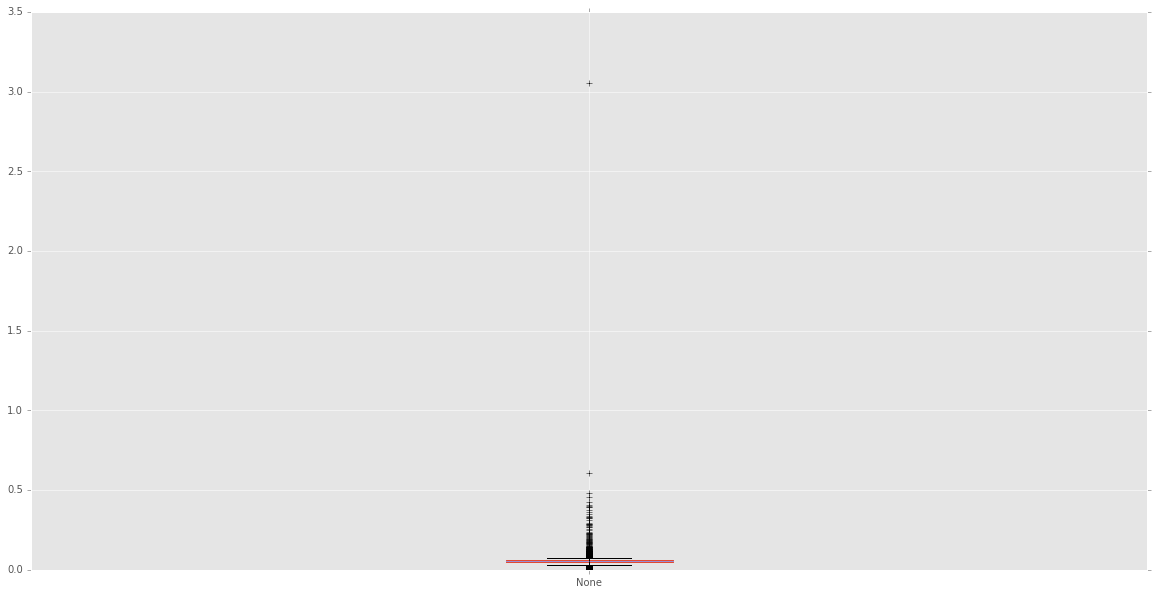

In [45]:
all_dist.plot(kind='box')

In [36]:
my_swims['delta'].sum()

-1572.005597179018

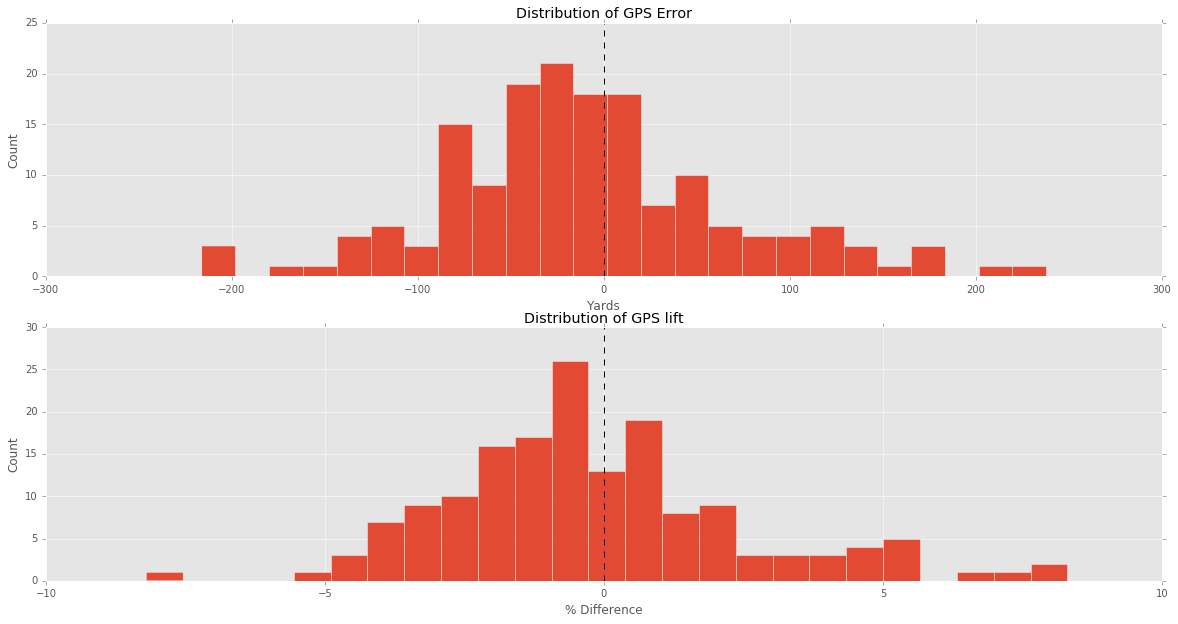

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=1)
my_swims.delta.hist(ax=axes[0], bins=25)
axes[0].axvline(0, color='k', linestyle='--')
axes[0].set_title('Distribution of GPS Error')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Yards')


(100*my_swims.ratio-100).hist(ax=axes[1], bins=25)
axes[1].axvline(0, color='k', linestyle='--')
axes[1].set_title('Distribution of GPS lift')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('% Difference')


In [29]:
my_swims[my_swims.delta==my_swims.delta.max()]

,average_speed,distance,elapsed_time,id,name,stroke_count,month,ds_week_ending,is_pool,approx_distance,delta,ratio
start_date,,,,,,,,,,,,
2016-08-01 07:16:15-07:00,0.913,3025.472065,3029.0,660947627,Morning Swim,72.2,Aug,2016-08-07,open water,3263.264007,237.791942,1.078597


In [31]:
my_swims[my_swims.delta==my_swims.delta.min()]

,average_speed,distance,elapsed_time,id,name,stroke_count,month,ds_week_ending,is_pool,approx_distance,delta,ratio
start_date,,,,,,,,,,,,
2016-06-11 08:12:40-07:00,1.123,11221.53221,9140.0,606266183,Lake DelValle!,76.2,Jun,2016-06-12,open water,11005.328277,-216.203933,0.980733


In [30]:
my_swims[my_swims.ratio==my_swims.ratio.max()]

,average_speed,distance,elapsed_time,id,name,stroke_count,month,ds_week_ending,is_pool,approx_distance,delta,ratio
start_date,,,,,,,,,,,,
2016-04-04 17:02:34-07:00,0.948,1610.778169,1553.0,536045820,Afternoon Swim,68.6,Apr,2016-04-10,open water,1744.550292,133.772123,1.083048


In [32]:
my_swims[my_swims.ratio==my_swims.ratio.min()]

,average_speed,distance,elapsed_time,id,name,stroke_count,month,ds_week_ending,is_pool,approx_distance,delta,ratio
start_date,,,,,,,,,,,,
2016-04-23 14:41:49-07:00,1.117,1551.067063,1270.0,554752952,Short Sunny Swim Fail,74.2,Apr,2016-04-24,open water,1422.489362,-128.577701,0.917104


In [33]:
my_swims[my_swims.name.apply(lambda x: 'Fail' in x)]

,average_speed,distance,elapsed_time,id,name,stroke_count,month,ds_week_ending,is_pool,approx_distance,delta,ratio
start_date,,,,,,,,,,,,
2016-04-23 14:41:49-07:00,1.117,1551.067063,1270.0,554752952,Short Sunny Swim Fail,74.2,Apr,2016-04-24,open water,1422.489362,-128.577701,0.917104
